In [2]:
%load_ext autoreload
%autoreload 2

In [28]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression, make_friedman1
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.formula.api import ols
import statsmodels.api as sm

# Plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Local imports
import helper

# Load dataset
We'll load the Anscombe dataset from seaborn. It includes all four datasets in a single pandas DataFrame with the "dataset" column differentiating them.

In [4]:
df = sns.load_dataset('anscombe')

In [5]:
df.head()

,dataset,x,y
0,I,10.0,8.04
1,I,8.0,6.95
2,I,13.0,7.58
3,I,9.0,8.81
4,I,11.0,8.33


In [6]:
df.shape

(44, 3)

In [7]:
df['dataset'].value_counts()

III    11
I      11
II     11
IV     11
Name: dataset, dtype: int64

# Split the data
Let's split up the data into our four different datasets. See the `helper.py` file for the helper functions used here and elsewhere throughout the notebook.

In [29]:
x1, y1 = helper.split_df_into_xy_dataset(df, "I")
x2, y2 = helper.split_df_into_xy_dataset(df, "II")
x3, y3 = helper.split_df_into_xy_dataset(df, "III")
x4, y4 = helper.split_df_into_xy_dataset(df, "IV")

# Convenience list for iterating through all datasets.
all_xy_pairs = [
    (x1, y1),
    (x2, y2),
    (x3, y3),
    (x4, y4)
]

dataset_names = ['I', 'II', 'III', 'IV']

# Plot the data
Let's get a look at these four famous plots!

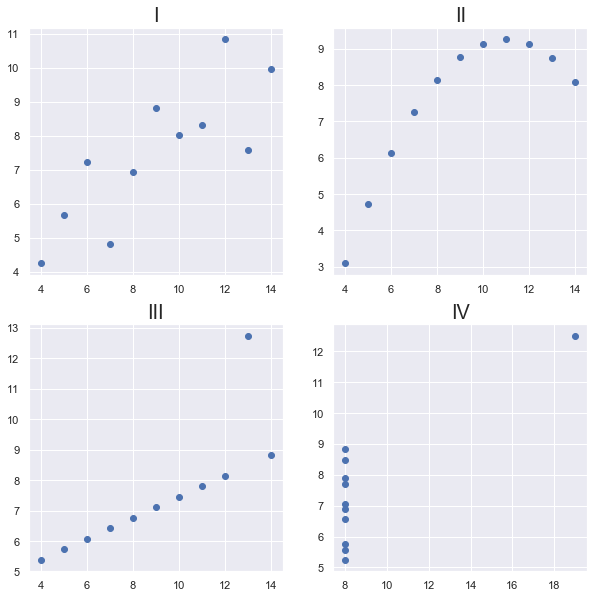

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()

for i, (name, (x, y)) in enumerate(zip(dataset_names, all_xy_pairs)):
    axs[i].set_title(name, fontsize=20)
    axs[i].scatter(x, y)

plt.show()

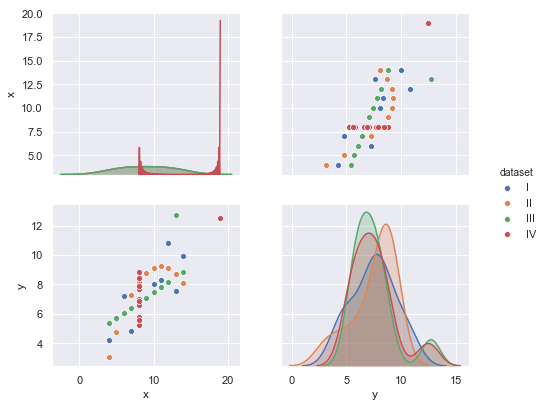

In [31]:
# What happens if we throw these the full DataFrame seaborn's pairplot and color by dataset?
# It's not that helpful, but it does look interesting.
g = sns.pairplot(df, hue='dataset')
g.fig.set_size_inches(8,6)

# Compute basic summary statistics
The point of Anscombe's Quadrant is to have very different datasets with the same basic summary statistics, so let's look at those basic summary statistics for each of our datasets.

In [32]:
# Summary statistics for each variable by itself.
for name, (x, y) in zip(dataset_names, all_xy_pairs):
    x_stats = helper.compute_univariate_stats(x)
    y_stats = helper.compute_univariate_stats(y)
    print(name)
    print("x:", x_stats)
    print("y:", y_stats)

I
x: {'mean': 9.0, 'standard deviation': 3.16}
y: {'mean': 7.5, 'standard deviation': 1.94}
II
x: {'mean': 9.0, 'standard deviation': 3.16}
y: {'mean': 7.5, 'standard deviation': 1.94}
III
x: {'mean': 9.0, 'standard deviation': 3.16}
y: {'mean': 7.5, 'standard deviation': 1.94}
IV
x: {'mean': 9.0, 'standard deviation': 3.16}
y: {'mean': 7.5, 'standard deviation': 1.94}


In [34]:
# Summary statistics for joint distribution of x and y.
for name, (x, y) in zip(dataset_names, all_xy_pairs):
    stats = helper.compute_bivariate_stats(x, y)
    print(name)
    print(stats)

I
{'correlation': 0.82, 'covariance': 5.5}
II
{'correlation': 0.82, 'covariance': 5.5}
III
{'correlation': 0.82, 'covariance': 5.5}
IV
{'correlation': 0.82, 'covariance': 5.5}


In [37]:
# Summary statistics for fitting a basic linear model to the data.
for name, (x, y) in zip(dataset_names, all_xy_pairs):
    stats = helper.compute_linear_model_stats(x, y)
    print(name)
    print(stats)

I
{'r_squared': 0.96, 'x_param': 0.8, 'mse': 2.46, 'bic': 42.5}
II
{'r_squared': 0.96, 'x_param': 0.8, 'mse': 2.47, 'bic': 42.5}
III
{'r_squared': 0.96, 'x_param': 0.8, 'mse': 2.47, 'bic': 42.5}
IV
{'r_squared': 0.96, 'x_param': 0.8, 'mse': 2.46, 'bic': 42.5}


We can see that the summary statistics here are identical across all four datasets, at least to the decimal places that we show here.

# Cross-Validation

In [40]:
# Summary statistics for fitting a basic linear model to the data.
for name, (x, y) in zip(dataset_names, all_xy_pairs):
    rmse = helper.calculate_cv_rmse(x, y)
    print(name)
    print({'rmse': rmse})

I
{'rmse': 1.3}
II
{'rmse': 1.31}
III
{'rmse': 1.53}
IV
{'rmse': 1.94}


# Plotting Multiple Models from Train-Test-Splits

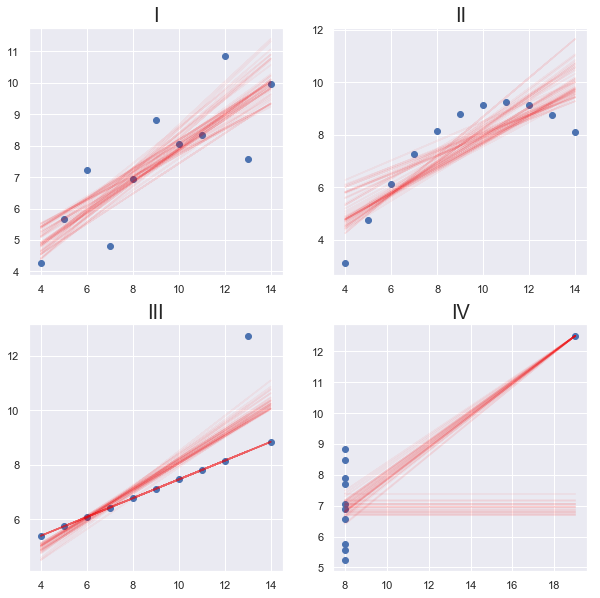

In [46]:
all_model_results = []
for x, y in all_xy_pairs:
    models, _, _ = run_regression_trials(x, y)
    all_model_results.append(models)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()

for i, results in enumerate(all_model_results):
    x = all_xy_pairs[i][0]
    y = all_xy_pairs[i][1]
    axs[i].set_title(dataset_names[i], fontsize=20)
    axs[i].scatter(x, y)
    for model in results:
        m = model.coef_[0, 0]
        b = model.intercept_[0]
        axs[i].plot(x, m*x + b, color='red', alpha=0.05)

plt.show()

In [56]:
for i, (name, (x, y)) in enumerate(zip(dataset_names, all_xy_pairs)):
    models, mse_vals, r2_vals = helper.run_regression_trials(x, y)
    print(name)
    print("MSE:", helper.compute_mean_and_95_quantiles(mse_vals))
    print("R^2:", helper.compute_mean_and_95_quantiles(r2_vals))

I
MSE: {'mean': 2.06, '95% confidence interval': [0.12, 4.28]}
R^2: {'mean': -1.14, '95% confidence interval': [-10.11, 0.96]}
II
MSE: {'mean': 3.07, '95% confidence interval': [0.65, 10.68]}
R^2: {'mean': -1.85, '95% confidence interval': [-17.22, 0.79]}
III
MSE: {'mean': 1.98, '95% confidence interval': [0.06, 6.01]}
R^2: {'mean': -0.46, '95% confidence interval': [-8.38, 0.74]}
IV
MSE: {'mean': 4.19, '95% confidence interval': [0.71, 12.11]}
R^2: {'mean': -1.4, '95% confidence interval': [-4.05, -0.0]}


# statsmodels OLS summary table

In [63]:
model_fit = sm.OLS(y1, sm.tools.tools.add_constant(x1)).fit()
model_fit.summary()

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     17.99
Date:                Tue, 24 Sep 2019   Prob (F-statistic):            0.00217
Time:                        14:08:18   Log-Likelihood:                -16.841
No. Observations:                  11   AIC:                             37.68
Df Residuals:                       9   BIC:                             38.48
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0001      1.125      2.667      0.026       0.456       5.544
x              0.5001      0.118      4.241      0.002       0.233       0.767
==============================================================================
Omnibus:                        0.082   Durbin-Watson:                   3.212
Prob(Omnibus):                  0.960   Jarque-Bera (JB):                0.289
Skew:                          -0.122   Prob(JB):                        0.865
Kurtosis:                       2.244   Cond. No.                         29.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [64]:
model_fit = sm.OLS(y2, sm.tools.tools.add_constant(x2)).fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     17.97
Date:                Tue, 24 Sep 2019   Prob (F-statistic):            0.00218
Time:                        14:08:24   Log-Likelihood:                -16.846
No. Observations:                  11   AIC:                             37.69
Df Residuals:                       9   BIC:                             38.49
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0009      1.125      2.667      0.026       0.455       5.547
x              0.5000      0.118      4.239      0.002       0.233       0.767
==============================================================================
Omnibus:                        1.594   Durbin-Watson:                   2.188
Prob(Omnibus):                  0.451   Jarque-Bera (JB):                1.108
Skew:                          -0.567   Prob(JB):                        0.575
Kurtosis:                       1.936   Cond. No.                         29.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [65]:
model_fit = sm.OLS(y3, sm.tools.tools.add_constant(x3)).fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     17.97
Date:                Tue, 24 Sep 2019   Prob (F-statistic):            0.00218
Time:                        14:08:30   Log-Likelihood:                -16.838
No. Observations:                  11   AIC:                             37.68
Df Residuals:                       9   BIC:                             38.47
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0025      1.124      2.670      0.026       0.459       5.546
x              0.4997      0.118      4.239      0.002       0.233       0.766
==============================================================================
Omnibus:                       19.540   Durbin-Watson:                   2.144
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               13.478
Skew:                           2.041   Prob(JB):                      0.00118
Kurtosis:                       6.571   Cond. No.                         29.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [66]:
model_fit = sm.OLS(y4, sm.tools.tools.add_constant(x4)).fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     18.00
Date:                Tue, 24 Sep 2019   Prob (F-statistic):            0.00216
Time:                        14:08:37   Log-Likelihood:                -16.833
No. Observations:                  11   AIC:                             37.67
Df Residuals:                       9   BIC:                             38.46
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0017      1.124      2.671      0.026       0.459       5.544
x              0.4999      0.118      4.243      0.002       0.233       0.766
==============================================================================
Omnibus:                        0.555   Durbin-Watson:                   1.662
Prob(Omnibus):                  0.758   Jarque-Bera (JB):                0.524
Skew:                           0.010   Prob(JB):                        0.769
Kurtosis:                       1.931   Cond. No.                         29.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""